# [Empowering Healthcare w/ Machine Learning: A Hands-On Approach](https://www.youtube.com/watch?v=XCqQtHwRnTQ)
by WiDS Kenya ambassadors Millicent Ochieng and Diana Mutheu

# Project Introduction

The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC. Each year, the survey collects responses from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services.

Explore some of the following research questions:

- Can survey questions from the BRFSS provide accurate predictions of whether an individual has diabetes?
- What risk factors are most predictive of diabetes risk?
- Can we use a subset of the risk factors to accurately predict whether an individual has diabetes?
- Can we create a short form of questions from the BRFSS using feature selection to accurately predict if someone might have diabetes or is at high risk of diabetes?

# Exploratory Data Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, \
    classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Set Seaborn style
sns.set_theme(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1, color_codes=True, rc=None)  # default

In [3]:
# Set font size
title_fontsize = 14
label_fontsize = 12
tick_fontsize = 10
text_fontsize = 10

In [4]:
# Set random state
random_state = 42

In [5]:
df = pd.read_csv('data/diabetes_binary_health_indicators_BRFSS2015.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_binary       253680 non-null  int64
 1   HighBP                253680 non-null  int64
 2   HighChol              253680 non-null  int64
 3   CholCheck             253680 non-null  int64
 4   BMI                   253680 non-null  int64
 5   Smoker                253680 non-null  int64
 6   Stroke                253680 non-null  int64
 7   HeartDiseaseorAttack  253680 non-null  int64
 8   PhysActivity          253680 non-null  int64
 9   Fruits                253680 non-null  int64
 10  Veggies               253680 non-null  int64
 11  HvyAlcoholConsump     253680 non-null  int64
 12  AnyHealthcare         253680 non-null  int64
 13  NoDocbcCost           253680 non-null  int64
 14  GenHlth               253680 non-null  int64
 15  MentHlth              253680 non-n

## `Diabetes_binary`
0 = Non-Diabetic

1 = Diabetic

Diabetes_binary
0    86.066698
1    13.933302
Name: proportion, dtype: float64


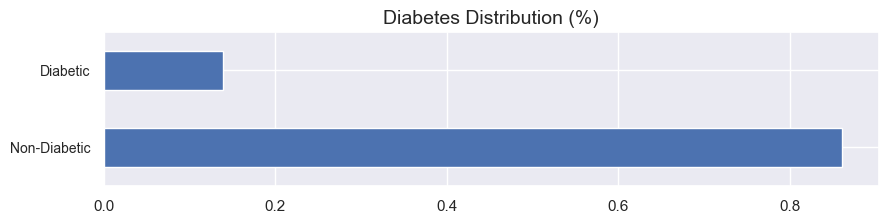

In [7]:
# First we will look for the distribution of diabetes in the data
print(df['Diabetes_binary'].value_counts(normalize=True) * 100)

series = df['Diabetes_binary'].copy()
series.name = None  # set the name of the Series to None to remove the column name (to prevent the column name from being displayed in the plot)
series.value_counts(normalize=True).plot(kind='barh', figsize=(10, 2))
plt.title('Diabetes Distribution (%)', fontsize=title_fontsize)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'], fontsize=tick_fontsize);  # semicolon to suppress output
# _ = plt.yticks(...)  # assign to a variable to suppress output

Let's see the characteristics of people with or without diabetes, this will help us in shaping our data and selecting the best features.

## `Sex`
0 = Male

1 = Female

In [8]:
df['Sex'].value_counts(normalize=True) * 100

Sex
0    55.965784
1    44.034216
Name: proportion, dtype: float64

In [9]:
df[df['Diabetes_binary']==1].Sex.value_counts(normalize=True) * 100  # almost equal dist of sex in people with diabetes

Sex
0    52.087931
1    47.912069
Name: proportion, dtype: float64

In [10]:
df[df['Diabetes_binary']==0].Sex.value_counts(normalize=True) * 100

Sex
0    56.593568
1    43.406432
Name: proportion, dtype: float64

## `Education`
This variable is a answer to Education level question:

What is the highest grade or year of school you completed?

1 = Never attended school or only kindergarten

2 = Grades 1 through 8 (Elementary)

3 = Grades 9 through 11 (Some high school)

4 = Grade 12 or GED (High school graduate)

5 = College 1 year to 3 years (Some college or technical school)

6 = College 4 years or more (College graduate)

In [11]:
df['Education'].value_counts(normalize=True) * 100

Education
6    42.307237
5    27.558341
4    24.735888
3     3.736203
2     1.593740
1     0.068590
Name: proportion, dtype: float64

In [12]:
df[df['Diabetes_binary']==1].Education.value_counts(normalize=True) * 100  # people with diabetes are slightly less college educated overall

Education
4    31.307644
6    29.423414
5    29.293272
3     6.495785
2     3.346913
1     0.132971
Name: proportion, dtype: float64

In [13]:
df[df['Diabetes_binary']==0].Education.value_counts(normalize=True) * 100

Education
6    44.392994
5    27.277474
4    23.671989
3     3.289456
2     1.309920
1     0.058168
Name: proportion, dtype: float64

## `Age`
1 = 18-24

2 = 25-29

3 = 30-34

4 = 35-39

5 = 40-44

6 = 45-49

7 = 50-54

8 = 55-59

9 = 60-64

10 = 65-69

11 = 70-74

12 = 75-79

13 = >80

In [14]:
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '>80']

In [15]:
df['Age'].value_counts(normalize=True) * 100

Age
9     13.104699
10    12.690792
8     12.153895
7     10.372911
11     9.276648
6      7.812599
13     6.844450
5      6.369048
12     6.299275
4      5.448991
3      4.384658
2      2.995112
1      2.246925
Name: proportion, dtype: float64

In [16]:
age_dist = df[df['Diabetes_binary']==1].Age.value_counts(normalize=True) * 100
age_dist

Age
10    18.553726
9     16.219657
11    14.544786
8     12.060771
12     9.627681
13     9.078821
7      8.736491
6      4.928422
5      2.973462
4      1.771063
3      0.888361
2      0.396084
1      0.220676
Name: proportion, dtype: float64

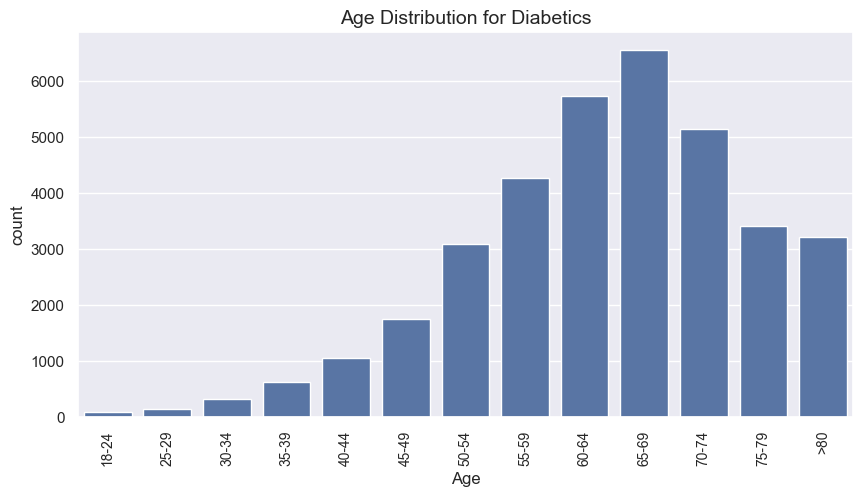

In [17]:
# Check age distribution for people with diabetes
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Age', data=df[df['Diabetes_binary']==1])
ax.set_title('Age Distribution for Diabetics', fontsize=title_fontsize)
ax.set_xticks(ticks=range(len(age_labels)), labels=age_labels, rotation=90, fontsize=tick_fontsize);

In [18]:
age_dist.head(8).sum()  # those >=45 years old are over 93% of all diabetic patients

np.float64(93.75035364680585)

In [19]:
age_dist2 = df[df['Diabetes_binary']==0].Age.value_counts(normalize=True) * 100
age_dist2

Age
9     12.600420
8     12.168970
10    11.741644
7     10.637830
11     8.423791
6      8.279517
5      6.918757
13     6.482728
4      6.044409
12     5.760440
3      4.950672
2      3.415867
1      2.574954
Name: proportion, dtype: float64

In [20]:
age_dist2 = age_dist2.to_frame()
age_dist2[age_dist2.index >= 6].sum()

proportion    76.09534
dtype: float64

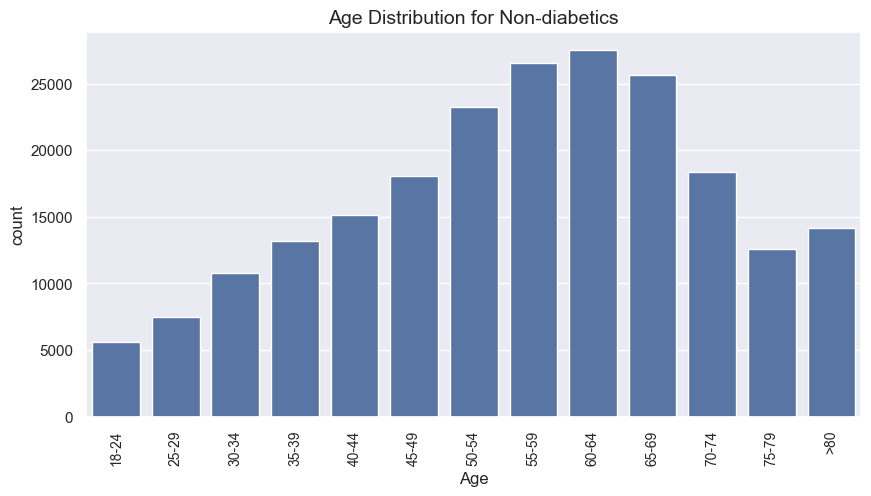

In [21]:
# Check age distribution for people without diabetes
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Age', data=df[df['Diabetes_binary']==0])
ax.set_title('Age Distribution for Non-diabetics', fontsize=title_fontsize)
ax.set_xticks(ticks=range(len(age_labels)), labels=age_labels, rotation=90, fontsize=tick_fontsize);

## `HighBP`

In [22]:
df[df['Diabetes_binary']==1].HighBP.value_counts(normalize=True) * 100

HighBP
1    75.267357
0    24.732643
Name: proportion, dtype: float64

In [23]:
df[df['Diabetes_binary']==0].HighBP.value_counts(normalize=True) * 100

HighBP
0    62.33981
1    37.66019
Name: proportion, dtype: float64

Incidence of `highBP` in diabetic patients is very high (75%), it is way lower in non-diabetic people (37%).

## `HighChol`

In [24]:
df[df['Diabetes_binary']==1].HighChol.value_counts(normalize=True) * 100

HighChol
1    67.011826
0    32.988174
Name: proportion, dtype: float64

In [25]:
df[df['Diabetes_binary']==0].HighChol.value_counts(normalize=True) * 100

HighChol
0    61.570346
1    38.429654
Name: proportion, dtype: float64

High cholesterol levels are common in diabetic patients, and much more lower in non-diabetic patients.

## `HeartDiseaseorAttack`

In [26]:
df[df['Diabetes_binary']==1].HeartDiseaseorAttack.value_counts(normalize=True) * 100

HeartDiseaseorAttack
0    77.711764
1    22.288236
Name: proportion, dtype: float64

In [27]:
df[df['Diabetes_binary']==0].HeartDiseaseorAttack.value_counts(normalize=True) * 100

HeartDiseaseorAttack
0    92.664908
1     7.335092
Name: proportion, dtype: float64

Patients with diabetes are 3 times more likely to have suffered a heart attack or gotten a heart disease.

## `Stroke`

In [28]:
df[df['Diabetes_binary']==1.0].Stroke.value_counts(normalize=True) * 100

Stroke
0    90.754258
1     9.245742
Name: proportion, dtype: float64

In [29]:
df[df['Diabetes_binary']==0.0].Stroke.value_counts(normalize=True) * 100

Stroke
0    96.782911
1     3.217089
Name: proportion, dtype: float64

Diabetic patients are almost 3 times more likely to have been diagnosed with stroke, although incidence is low in both cases.

## `BMI`

According to WHO classification, a BMI

< 18.5 = Underweight

18.5-24.9 = Healthy

25-29.9 = Overweight

30-39.9 = Obese

\>= 40.0 = Morbid Obese

BMI is a major risk factor in diabetes, people who are overweight are at an enhanced risk of especially developing type 2 diabetes.

In [30]:
bmi_boundries = [18.5, 24.9, 29.9, 39.9]
annotation_xs = [bb - 3 for bb in bmi_boundries + [60]]
annotation_vs = ['$Underweight$', '$Normal$', '$Overweight$', '$Obesity$', '$Morbid\\ Obesity$']

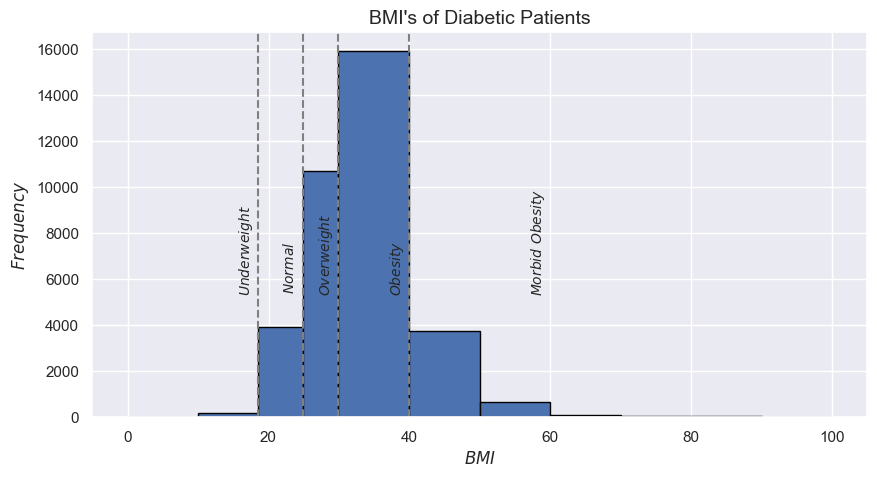

In [31]:
plt.figure(figsize=(10, 5))

for i, bb in enumerate(bmi_boundries):
    plt.axvline(bb, color='gray', linestyle='--')
    plt.text(annotation_xs[i], 5500, annotation_vs[i], rotation=90, size=text_fontsize)
plt.text(annotation_xs[-1], 5500, annotation_vs[-1], rotation=90, size=text_fontsize)

plt.hist(df[df['Diabetes_binary']==1].BMI, edgecolor='black', bins=[0, 10] + bmi_boundries + [50, 60, 70, 80, 90, 100])
plt.xlabel('$BMI$', fontsize=label_fontsize)
plt.ylabel('$Frequency$', fontsize=label_fontsize)
plt.title("BMI's of Diabetic Patients", fontsize=title_fontsize);

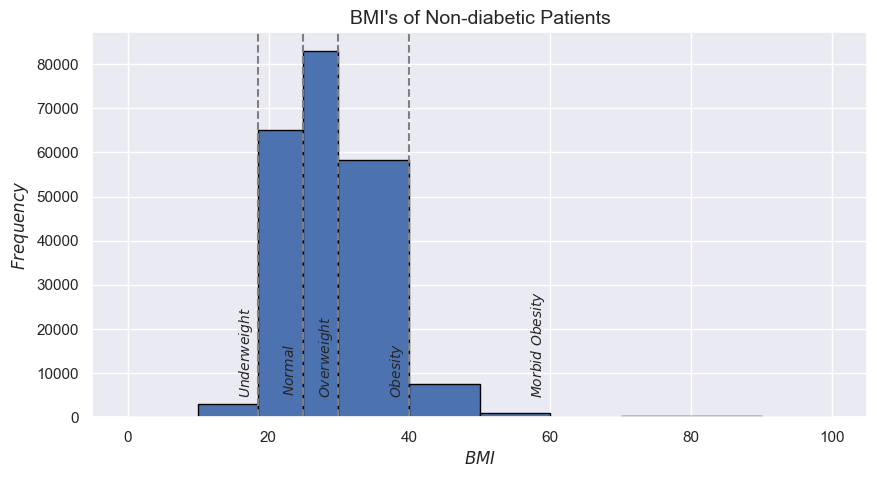

In [32]:
plt.figure(figsize=(10, 5))

for i, bb in enumerate(bmi_boundries):
    plt.axvline(bb, color='gray', linestyle='--')
    plt.text(annotation_xs[i], 5500, annotation_vs[i], rotation=90, size=text_fontsize)
plt.text(annotation_xs[-1], 5500, annotation_vs[-1], rotation=90, size=text_fontsize)

plt.hist(df[df['Diabetes_binary']==0].BMI, edgecolor='black', bins=[0, 10] + bmi_boundries + [50, 60, 70, 80, 90, 100])
plt.xlabel('$BMI$', fontsize=label_fontsize)
plt.ylabel('$Frequency$', fontsize=label_fontsize)
plt.title("BMI's of Non-diabetic Patients", fontsize=title_fontsize);

## Others

In [33]:
# Hasn't fallen sick in the last 30 days and feels excellent or very good
df['PerfectHlth'] = (df['PhysHlth']==0) & (df['GenHlth']<3)
df['PerfectHlth'] = df['PerfectHlth'].astype(int)

In [34]:
# No single issue with heart disease or BP or Chol
df['NoHrtIssue'] = (df['HighBP']==0) & (df['HighChol']==0) & (df['HeartDiseaseorAttack']==0)
df['NoHrtIssue'] = df['NoHrtIssue'].astype(int)

In [35]:
# Diabetics would most likely feel unwell and in a slightly poorer state of health
df['HlthNotGood'] = df['GenHlth'] > 3
df['HlthNotGood'] = df['HlthNotGood'].astype(int)
df['HlthAboveGood'] = df['GenHlth'] < 3
df['HlthAboveGood'] = df['HlthAboveGood'].astype(int)

In [36]:
# Unwell & difficulty walking because of low or excess sugar (check to confirm)
df['HlthNotGood&DiffWalk'] = (df['GenHlth']>3) & (df['DiffWalk']==1)
df['HlthNotGood&DiffWalk'] = df['HlthNotGood&DiffWalk'].astype(int)

In [37]:
# Type 2 diabetes being age-related: people with high blood pressure and heart disease/illness (more prevalent with aging)
df['HBP&HA'] = (df['HighBP']==1) & (df['HeartDiseaseorAttack']==1)
df['HBP&HA'] = df['HBP&HA'].astype(int)
df['HBP&HA'].value_counts()

HBP&HA
0    235752
1     17928
Name: count, dtype: int64

In [38]:
df['Older&Poor'] = (df['Age']>5) & (df['Income']<5)
df['Older&Poor'] = df['Older&Poor'].astype(int)
df['Older&Poor'].value_counts()

Older&Poor
0    206599
1     47081
Name: count, dtype: int64

## Plot the correlation

Correlation of each feature to diabetes (+v implies correlation to diabetes, -v implies correlation to being non-diabetic)

In [39]:
df_corr = df.corr(numeric_only=True)
df_corr['Diabetes_binary'].sort_values(ascending=False)

Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
HlthNotGood             0.249898
DiffWalk                0.218344
BMI                     0.216843
HlthNotGood&DiffWalk    0.211009
HighChol                0.200276
HBP&HA                  0.185759
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Older&Poor              0.166253
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
PerfectHlth            -0.206849
NoHrtIssue             -0.234274
HlthAboveGood          -0.255507
Name: Diabetes_binary, dtype: float64

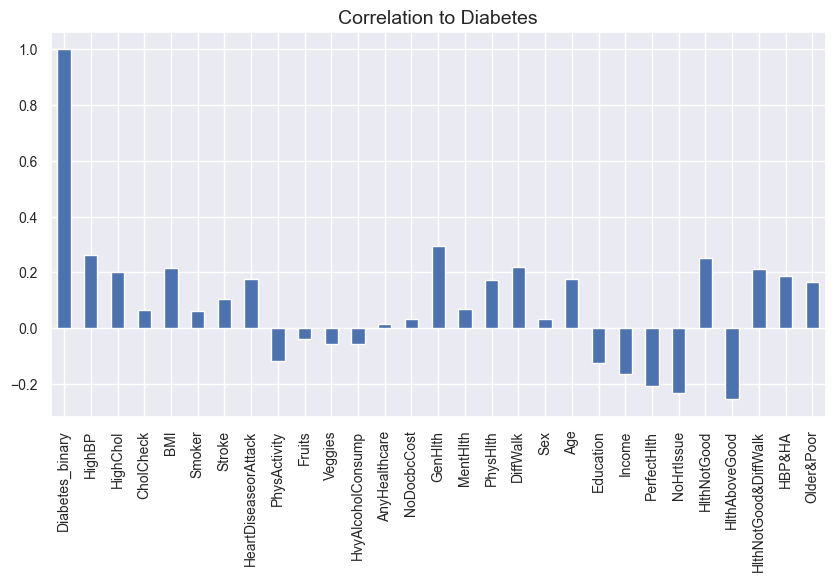

In [40]:
df.corrwith(df.Diabetes_binary).plot(kind='bar', figsize=(10, 5), fontsize=tick_fontsize, rot=90)
plt.title("Correlation to Diabetes", fontsize=title_fontsize);

# Data Preparation


## Drop irrelevant features

In [41]:
df2 = df.drop(['Fruits', 'Veggies', 'AnyHealthcare', 'NoDocbcCost', 'Income', 'Education', 'CholCheck'], axis=1)

In [42]:
df3 = df2.copy()
df3.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'PerfectHlth',
       'NoHrtIssue', 'HlthNotGood', 'HlthAboveGood', 'HlthNotGood&DiffWalk',
       'HBP&HA', 'Older&Poor'],
      dtype='object')

## Encode categorical features

In [43]:
cat_feats=['Diabetes_binary', 'HighBP', 'HighChol', 'Smoker', 'Stroke', 
           'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 'GenHlth', 
           'DiffWalk', 'Sex', 'PerfectHlth', 
           'NoHrtIssue', 'HlthNotGood', 'HlthAboveGood', 'HlthNotGood&DiffWalk', 
           'HBP&HA', 'Older&Poor']
le = LabelEncoder()
for col in cat_feats:
    df3[col]=le.fit_transform(df3[col])

## Drop duplicates

In [44]:
df3.duplicated().sum()

np.int64(85170)

In [45]:
df3[df3.duplicated()]["Diabetes_binary"].value_counts()

Diabetes_binary
0    82175
1     2995
Name: count, dtype: int64

In [46]:
df3.drop_duplicates()

,Diabetes_binary,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,...,DiffWalk,Sex,Age,PerfectHlth,NoHrtIssue,HlthNotGood,HlthAboveGood,HlthNotGood&DiffWalk,HBP&HA,Older&Poor
0,0,1,1,40,1,0,0,0,0,4,...,1,0,9,0,0,1,0,1,0,1
1,0,0,0,25,1,0,0,1,0,2,...,0,0,7,0,1,0,0,0,0,1
2,0,1,1,28,0,0,0,0,0,4,...,1,0,9,0,0,1,0,1,0,0
3,0,1,0,27,0,0,0,1,0,1,...,0,0,11,1,0,0,1,0,0,0
4,0,1,1,24,0,0,0,1,0,1,...,0,0,11,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253673,0,1,0,42,0,0,0,1,0,2,...,0,1,3,0,0,0,0,0,0,0
253675,0,1,1,45,0,0,0,0,0,2,...,0,1,5,0,0,0,0,0,0,0
253676,1,1,1,18,0,0,0,0,0,3,...,1,0,11,0,0,1,0,1,0,1
253678,0,1,0,23,0,0,0,0,0,2,...,0,1,7,0,0,0,0,0,0,1


In [47]:
df3['Diabetes_binary'].value_counts(normalize=True) * 100

Diabetes_binary
0    86.066698
1    13.933302
Name: proportion, dtype: float64

## Construct `X` and `y`

In [48]:
X = df3.drop('Diabetes_binary', axis=1)
y = df3['Diabetes_binary']

### Use `Random Oversampler` to balance target label

In [49]:
OverS = RandomOverSampler(random_state=random_state, sampling_strategy='not majority')
X_over, y_over = OverS.fit_resample(X, y)

In [50]:
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, random_state=random_state)

In [51]:
X_over

,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,...,DiffWalk,Sex,Age,PerfectHlth,NoHrtIssue,HlthNotGood,HlthAboveGood,HlthNotGood&DiffWalk,HBP&HA,Older&Poor
0,1,1,40,1,0,0,0,0,4,18,...,1,0,9,0,0,1,0,1,0,1
1,0,0,25,1,0,0,1,0,2,0,...,0,0,7,0,1,0,0,0,0,1
2,1,1,28,0,0,0,0,0,4,30,...,1,0,9,0,0,1,0,1,0,0
3,1,0,27,0,0,0,1,0,1,0,...,0,0,11,1,0,0,1,0,0,0
4,1,1,24,0,0,0,1,0,1,3,...,0,0,11,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436663,1,1,28,0,0,1,1,0,4,2,...,1,0,8,0,0,1,0,1,1,1
436664,1,1,30,1,1,1,0,0,3,30,...,1,0,12,0,0,1,0,1,1,1
436665,1,1,36,0,1,1,0,0,1,0,...,1,0,10,0,0,0,1,0,1,0
436666,1,1,30,0,0,0,0,0,3,15,...,1,1,7,0,0,1,0,1,0,0


# Modelling

In [52]:
# A function that outputs our model's performance metrics
def train_evaluate_model(predictions, y_test):
    # larger is better
    accuracy = accuracy_score(y_test, predictions)                      # the ratio of correctly predicted instances to the total number of instances
    precision = precision_score(y_test, predictions, average='micro')   # TP / (TP + FP), counting the total TP and FP over all classes
    recall = recall_score(y_test, predictions, average='micro')         # TP / (TP + FN), counting the total TP and FN over all classes
    f1 = f1_score(y_test, predictions, average='micro')                 # 2 * precision * recall / (precision + recall), counting over all classes
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)    # the average of recall obtained on each class
    auc = roc_auc_score(y_test, predictions, multi_class='ovr')         # Area Under the Receiver Operating Characteristic Curve (AUC-ROC)
                                                                        # provides a single scalar value that summarizes the performance of a binary classifier across all possible thresholds
                                                                        # ROC curve is a plot of the TPR (recall) against the FPR (FP / (FP + TN)) at various threshold settings
                                                                        # 'ovr' (One-vs-Rest): Computes the AUC of each class against all other classes

    # a dataframe to visualize the results
    eval_df = pd.DataFrame([[accuracy, precision, recall, f1, balanced_accuracy, auc]], columns=['accuracy', 'precision', 'recall', 'f1_score', 'balanced_accuracy', 'auc'])
    return eval_df

## Decision Tree

In [54]:
dtc = DecisionTreeClassifier(random_state=random_state)
dtc.fit(X_over_train, y_over_train)
DecisionTree_over_predictions = dtc.predict(X_over_test)
DecisionTree_over_score = train_evaluate_model(DecisionTree_over_predictions, y_over_test)
DecisionTree_over_score.index = ['Decision Tree - over sampling']
DecisionTree_over_score.style.background_gradient(cmap=sns.color_palette("Greens", as_cmap=True))

,accuracy,precision,recall,f1_score,balanced_accuracy,auc
Decision Tree - over sampling,0.890031,0.890031,0.890031,0.890031,0.890173,0.890173


In [55]:
print('Decision Tree:')
print(classification_report(y_over_test, DecisionTree_over_predictions, target_names=['non-diabetic', 'diabetic']))

Decision Tree:
              precision    recall  f1-score   support

non-diabetic       0.94      0.83      0.88     43773
    diabetic       0.85      0.95      0.90     43561

    accuracy                           0.89     87334
   macro avg       0.90      0.89      0.89     87334
weighted avg       0.90      0.89      0.89     87334



Recall is very important in medical domains (e.g., identifying cancer), where you really want to minimize the chance of missing positive cases (predicting false negatives). These are typically cases where missing a positive case has a much bigger cost than wrongly classifying something as positive.

The Recall score of this model is 0.95, i.e., 95% of all cases will be correctly identified. The precision is not that high at 86%, but is less problematic for the community (and the patient) than a false negative will be.

## Random Forest

### w/ `GridSearchCV`

In [ ]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20]
}

RF_grid_search_ = GridSearchCV(rfc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=3)
RF_grid_search_.fit(X_over_train, y_over_train)

In [ ]:
RF_grid_search_.best_params_

In [ ]:
RF_grid_search_.best_estimator_

In [56]:
rfc_grid_search_best = RandomForestClassifier(max_depth=20, n_estimators=200)
rfc_grid_search_best.fit(X_over_train, y_over_train)
RandomForestGridSearchBest_over_predctions = rfc_grid_search_best.predict(X_over_test)
RandomForestGridSearchBest_over_score = train_evaluate_model(RandomForestGridSearchBest_over_predctions, y_over_test)
RandomForestGridSearchBest_over_score.index = ['Random Forest Grid Search Best - over sampling']
RandomForestGridSearchBest_over_score.style.background_gradient(cmap=sns.color_palette("Greens", as_cmap=True))

,accuracy,precision,recall,f1_score,balanced_accuracy,auc
Random Forest Grid Search Best - over sampling,0.874791,0.874791,0.874791,0.874791,0.874927,0.874927


In [57]:
print('Random Forest Grid Search Best:')
print(classification_report(y_over_test, RandomForestGridSearchBest_over_predctions, target_names=['non-diabetic', 'diabetic']))

Random Forest Grid Search Best:
              precision    recall  f1-score   support

non-diabetic       0.92      0.82      0.87     43773
    diabetic       0.84      0.93      0.88     43561

    accuracy                           0.87     87334
   macro avg       0.88      0.87      0.87     87334
weighted avg       0.88      0.87      0.87     87334



### w/o `GridSearchCV`

In [58]:
rfc = RandomForestClassifier()
rfc.fit(X_over_train, y_over_train)
RandomForestNoHyperparameterTuning_over_predctions = rfc.predict(X_over_test)
RandomForestNoHyperparameterTuning_over_score = train_evaluate_model(RandomForestNoHyperparameterTuning_over_predctions, y_over_test)
RandomForestNoHyperparameterTuning_over_score.index = ["Random Forest No Hyperparameter Tuning - over sampling"]
RandomForestNoHyperparameterTuning_over_score.style.background_gradient(cmap=sns.color_palette("Greens", as_cmap=True))

,accuracy,precision,recall,f1_score,balanced_accuracy,auc
Random Forest No Hyperparameter Tuning - over sampling,0.900692,0.900692,0.900692,0.900692,0.900821,0.900821


In [59]:
print('Random Forest No Hyperparameter Tuning:')
print(classification_report(y_over_test, RandomForestNoHyperparameterTuning_over_predctions, target_names=['non-diabetic', 'diabetic']))

Random Forest No Hyperparameter Tuning:
              precision    recall  f1-score   support

non-diabetic       0.95      0.85      0.90     43773
    diabetic       0.86      0.95      0.91     43561

    accuracy                           0.90     87334
   macro avg       0.91      0.90      0.90     87334
weighted avg       0.91      0.90      0.90     87334



Random forest without any hyperparameter tuning performed well with acceptable accuracy and recall.

In [60]:
# Check feature importance
for name, score in zip(X_over, rfc.feature_importances_):
    print(name, score)

HighBP 0.05978569026822087
HighChol 0.026833163426499405
BMI 0.23470274057346752
Smoker 0.027298374246951067
Stroke 0.011294579955339522
HeartDiseaseorAttack 0.008042923442657383
PhysActivity 0.023938490374591812
HvyAlcoholConsump 0.010038372712105453
GenHlth 0.06687164991743251
MentHlth 0.07936262735912328
PhysHlth 0.09465836829913644
DiffWalk 0.01693591980959868
Sex 0.024730459020083865
Age 0.15777296263521076
PerfectHlth 0.02374783017123814
NoHrtIssue 0.04500969130060873
HlthNotGood 0.01491993295410077
HlthAboveGood 0.04289469357230535
HlthNotGood&DiffWalk 0.00597997823474768
HBP&HA 0.004875378754882744
Older&Poor 0.0203061729716978


## XGB

In [61]:
xgbc = XGBClassifier(learning_rate=0.1)
xgbc.fit(X_over_train, y_over_train)
XGB_over_predctions = xgbc.predict(X_over_test)
XGB_over_score = train_evaluate_model(XGB_over_predctions, y_over_test)
XGB_over_score.index = ["XGB - over sampling"]
XGB_over_score.style.background_gradient(cmap=sns.color_palette("Greens", as_cmap=True))

,accuracy,precision,recall,f1_score,balanced_accuracy,auc
XGB - over sampling,0.759200,0.759200,0.759200,0.759200,0.759316,0.759316


# Summary

In [62]:
all_predictions = pd.concat([DecisionTree_over_score, 
                             RandomForestGridSearchBest_over_score, 
                             RandomForestNoHyperparameterTuning_over_score, 
                             XGB_over_score], 
                             axis=0)
all_predictions.style.background_gradient(cmap=sns.color_palette("Greens", as_cmap=True))

,accuracy,precision,recall,f1_score,balanced_accuracy,auc
Decision Tree - over sampling,0.890031,0.890031,0.890031,0.890031,0.890173,0.890173
Random Forest Grid Search Best - over sampling,0.874791,0.874791,0.874791,0.874791,0.874927,0.874927
Random Forest No Hyperparameter Tuning - over sampling,0.900692,0.900692,0.900692,0.900692,0.900821,0.900821
XGB - over sampling,0.759200,0.759200,0.759200,0.759200,0.759316,0.759316


## Conclusion
The features that correlated with diabetes are: GenHlth, HighBP, HlthNotGood, DiffWalk, BMI, HlthNotGood&DiffWalk, HighChol, HBP&HA, Age, HeartDiseaseorAttack, PhysHlth, Older&Poor.

The model with best performance is the random forest (no hyperparameter tuning) with Random Overrsampling.

Our best model performance has 0.90 accuracy with recall of 0.95 for the diabetic class.

## Plot confusion matrix of best 2 model

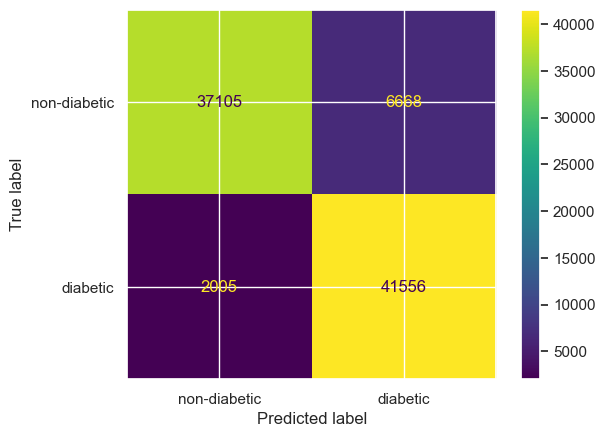

In [63]:
cm = confusion_matrix(y_over_test, RandomForestNoHyperparameterTuning_over_predctions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-diabetic", "diabetic"])
disp.plot()
plt.show()

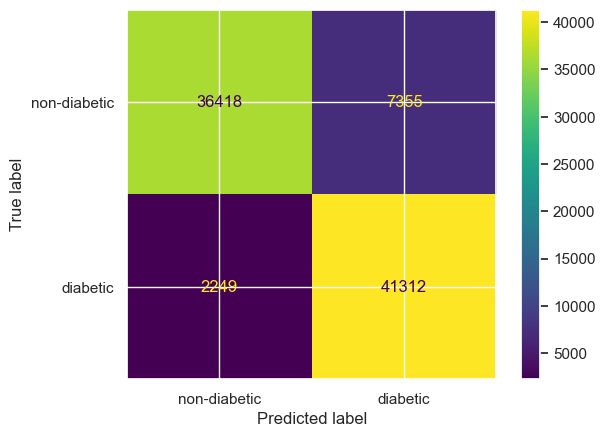

In [64]:
cm = confusion_matrix(y_over_test, DecisionTree_over_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-diabetic", "diabetic"])
disp.plot()
plt.show()